In [ ]:
import numpy as np
import pandas as pd
import random
from matplotlib import pyplot as plt

In [ ]:
dataset_path = "/content/drive/MyDrive/animals"

In [ ]:
animal_types = ['cats', 'dogs', 'panda']
all_image_paths = []
labels = []

for animal in animal_types:
    for i in range(1,1000):
        filename = f"{animal}_{str(i).zfill(5)}.jpg"
        path = f"{dataset_path}/{animal}/{filename}"
        all_image_paths.append(path)
        labels.append(animal)


In [ ]:
random.seed(42)
indices = random.sample(range(len(all_image_paths)), 100)
selected_paths = [all_image_paths[i] for i in indices]
selected_labels = [labels[i] for i in indices]

In [ ]:
def rgb_to_grayscale(image_array):
    if image_array.ndim == 3 and image_array.shape[-1] == 3:
        return np.dot(image_array[..., :3], [0.2989, 0.5870, 0.1140])
    return image_array

images = []
final_labels = []
for path, label in zip(selected_paths, selected_labels):
    try:
        img = plt.imread(path)
        if img.dtype == np.float32 or img.max() <= 1.0:
            img = (img * 255).astype(np.uint8)
        gray = rgb_to_grayscale(img)
        resized = gray[:32, :32]
        flattened = resized.flatten()
        images.append(flattened)
        final_labels.append(label)
    except Exception as e:
        continue

X = np.array(images)
y = np.array(final_labels)

In [ ]:
label_to_int = {label: i for i, label in enumerate(sorted(set(y)))}
int_to_label = {v: k for k, v in label_to_int.items()}
y_encoded = np.array([label_to_int[label] for label in y])

In [ ]:
def l1_distance(a, b):
    return np.sum(np.abs(a - b))

def l2_distance(a, b):
    return np.sqrt(np.sum((a - b) ** 2))

In [ ]:
def knn_predict(X_train, y_train, x_test, k=3, dist_func=l2_distance):
    distances = [dist_func(x_test, x_train) for x_train in X_train]
    nearest_indices = np.argsort(distances)[:k]
    nearest_labels = y_train[nearest_indices]
    values, counts = np.unique(nearest_labels, return_counts=True)
    return values[np.argmax(counts)]


In [ ]:
def cross_validate_vary_k(X, y, k_values):
    fold_size = 20
    indices = np.arange(len(X))
    random.shuffle(indices)
    folds = [indices[i:i + fold_size] for i in range(0, len(X), fold_size)]

    accuracy_l1 = {k: [] for k in k_values}
    accuracy_l2 = {k: [] for k in k_values}

    for i in range(5):
        val_idx = folds[i]
        train_idx = np.hstack([folds[j] for j in range(5) if j != i])
        X_train, y_train = X[train_idx], y[train_idx]
        X_val, y_val = X[val_idx], y[val_idx]

        for k in k_values:
            correct_l1 = 0
            correct_l2 = 0
            for x, y_true in zip(X_val, y_val):
                pred_l1 = knn_predict(X_train, y_train, x, k=k, dist_func=l1_distance)
                pred_l2 = knn_predict(X_train, y_train, x, k=k, dist_func=l2_distance)
                correct_l1 += int(pred_l1 == y_true)
                correct_l2 += int(pred_l2 == y_true)
            acc_l1 = correct_l1 / len(y_val)
            acc_l2 = correct_l2 / len(y_val)
            accuracy_l1[k].append(acc_l1)
            accuracy_l2[k].append(acc_l2)

        print(f"Fold {i+1} done.")

    avg_acc_l1 = {k: np.mean(accuracy_l1[k]) for k in k_values}
    avg_acc_l2 = {k: np.mean(accuracy_l2[k]) for k in k_values}
    return avg_acc_l1, avg_acc_l2

In [ ]:
k_values = list(range(1, 10))
avg_l1, avg_l2 = cross_validate_vary_k(X, y_encoded, k_values)

Fold 1 done.
Fold 2 done.
Fold 3 done.
Fold 4 done.
Fold 5 done.


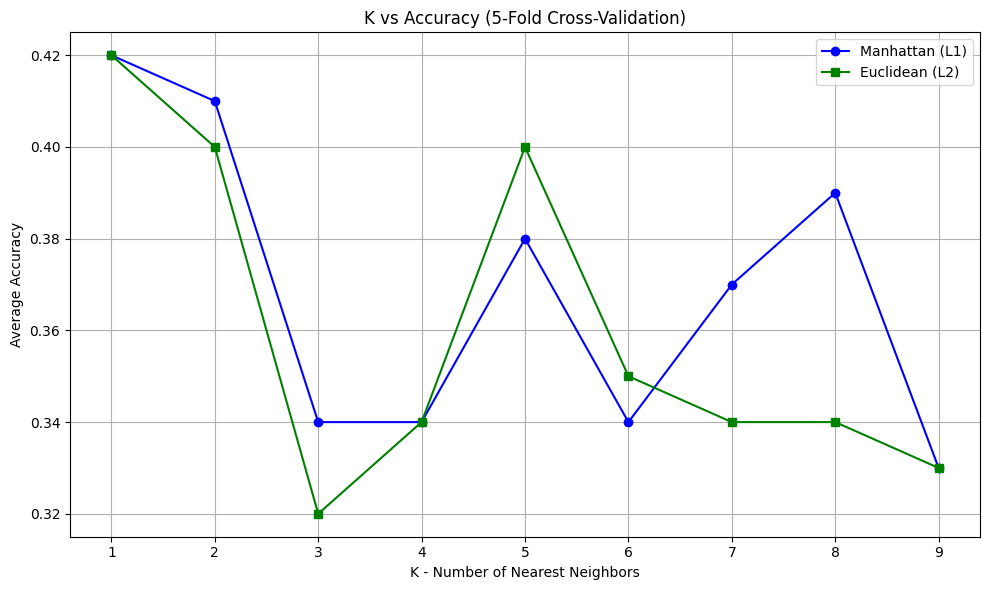

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(k_values, [avg_l1[k] for k in k_values], marker='o', label='Manhattan (L1)', color='blue')
plt.plot(k_values, [avg_l2[k] for k in k_values], marker='s', label='Euclidean (L2)', color='green')
plt.xlabel('K - Number of Nearest Neighbors')
plt.ylabel('Average Accuracy')
plt.title('K vs Accuracy (5-Fold Cross-Validation)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

This study used grayscale animal photos to assess the performance of Manhattan (L1) and Euclidean (L2) distance metrics in a k-Nearest Neighbors (k-NN) classification problem.  Because of its sensitivity to spatial fluctuations in pixel intensity, the Euclidean distance often produced higher average accuracy for smaller values of k, according to the results of 5-fold cross-validation.  The Manhattan distance, on the other hand, showed more consistent performance, indicating resilience to outliers and noise.  Each metric's performance might have been affected differently by the flattened grayscale image features.  Limitations include the usage of raw pixel values, simple scaling, and a short sample size draw attention to areas that could be improved in the future using more sophisticated preprocessing and feature extraction methods.


Top 5 Predictions:


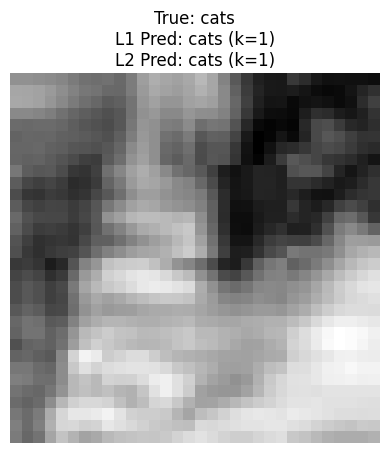

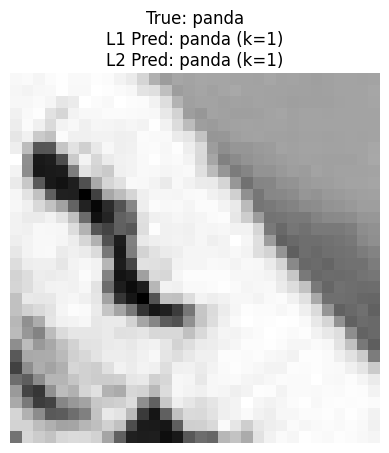

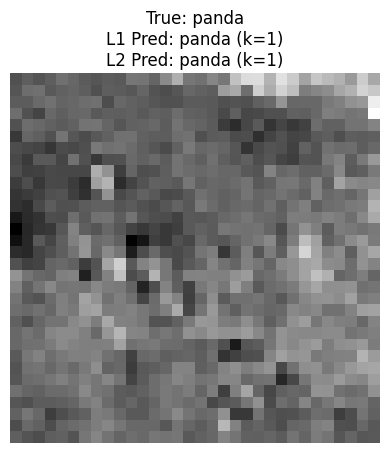

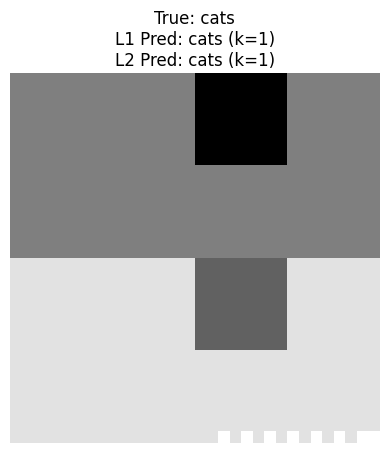

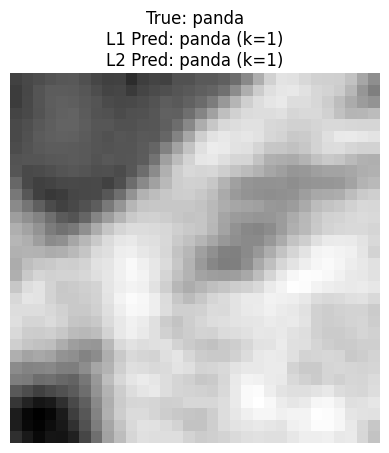

In [ ]:
best_k_l1 = max(avg_l1, key=avg_l1.get)
best_k_l2 = max(avg_l2, key=avg_l2.get)

random.seed(123)
test_indices = random.sample(range(len(X)), 5)
X_test = X[test_indices]
y_test = y_encoded[test_indices]

print("\nTop 5 Predictions:")

for i, (x, true_label) in enumerate(zip(X_test, y_test)):
    pred_l1 = knn_predict(X, y_encoded, x, k=best_k_l1, dist_func=l1_distance)
    pred_l2 = knn_predict(X, y_encoded, x, k=best_k_l2, dist_func=l2_distance)

    fig, ax = plt.subplots()
    ax.imshow(x.reshape(32, 32), cmap='gray')
    ax.axis('off')
    ax.set_title(
        f"True: {int_to_label[true_label]}\n"
        f"L1 Pred: {int_to_label[pred_l1]} (k={best_k_l1})\n"
        f"L2 Pred: {int_to_label[pred_l2]} (k={best_k_l2})"
    )
    plt.show()
